In [97]:
# PART 1
! pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn mlflow

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn


In [98]:

# Load the data
data = pd.read_csv('dataset_all.csv')

# Preprocess the data
def handle_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    selected_columns = ['H', 'diameter',  'q', 'i',  'moid', 'pha']
    data = data[selected_columns]
    for column in selected_columns:
        if data[column].dtype == 'float64':
            data[column].fillna(data[column].mean(), inplace=True)
        elif data[column].dtype == 'object':
            data[column].fillna(data[column].mode()[0], inplace=True)
    return data

data = handle_missing_values(data)


/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30459/621207532.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset_all.csv')
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30459/621207532.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column].fillna(data[column].mean(), inplace=True)
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30459/621207532.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column].fillna(data[column].mode()[0], inplace=True)


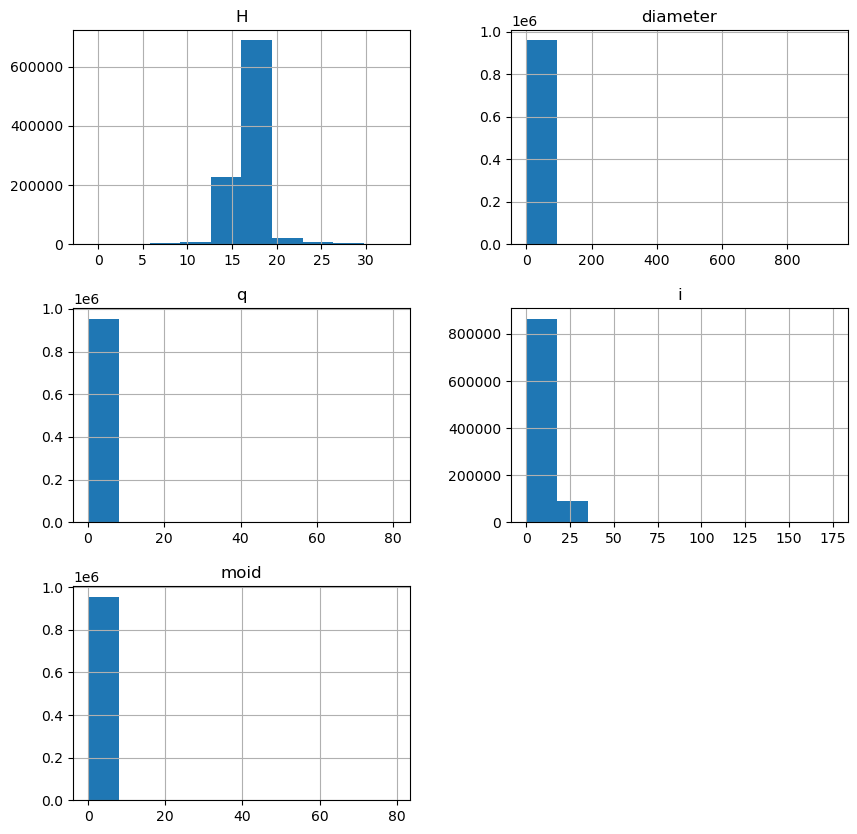

/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_30459/397587589.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


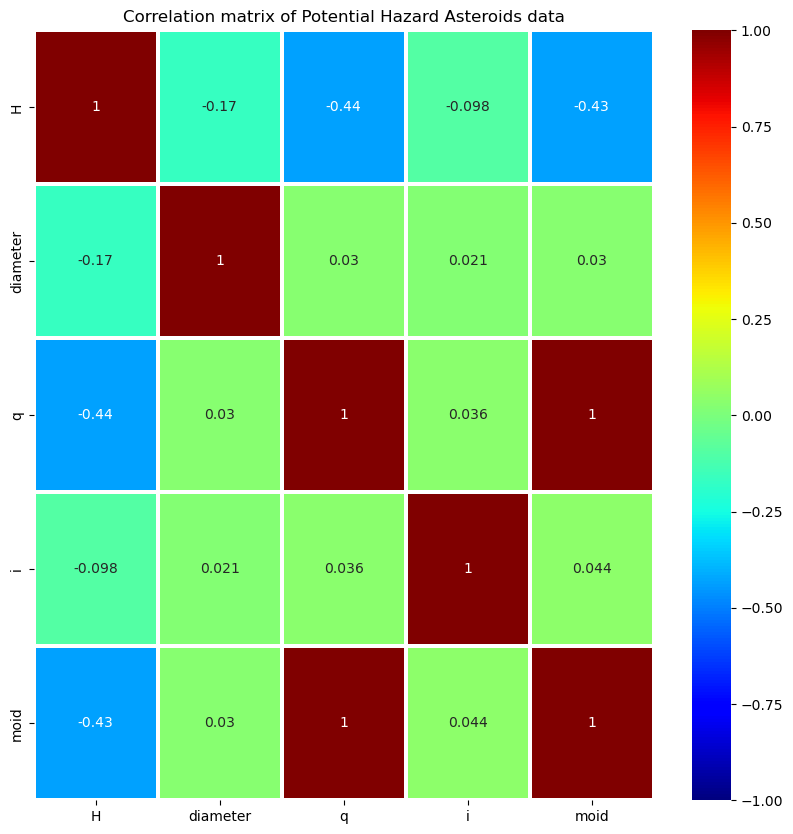

In [99]:

# Visualize the data
data.hist(figsize=(10, 10))
plt.show()

correlation_matrix = data.corr()
plt.figure(figsize=(10, 10))
plt.title("Correlation matrix of Potential Hazard Asteroids data")
sns.heatmap(data=correlation_matrix, cmap='jet', vmin=-1, vmax=1, linewidth=1.5, annot=True)
plt.show()

In [100]:


# Split the dataset
def select_features_and_target(data: pd.DataFrame) -> tuple:
    features = data[['H', 'diameter',  'q', 'i', 'moid']]
    target = data['pha'].apply(lambda x: 1 if x == 'Y' else 0)
    return features, target

# # Oversample the data
# def oversample_data(X: pd.DataFrame, y: pd.Series):
#     oversampler = SMOTE(sampling_strategy='minority', random_state=42)
#     X_resampled, y_resampled = oversampler.fit_resample(X, y)
#     return X_resampled, y_resampled


# # Apply oversampling to the whole dataset
# X_oversampled, y_oversampled = oversample_data(features, target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(y_train.value_counts())
print(y_test.value_counts())



0    765176
1      1643
Name: pha, dtype: int64
0    191282
1       423
Name: pha, dtype: int64


In [101]:
# Load the best model
run_id = "f559613a6c2547aab24df8c35cc7be53"
name = "RandomForest3_10"
model = mlflow.sklearn.load_model(f"./mlruns/mlartifacts/0/{run_id}/artifacts/model")

# Evaluate the model
y_pred = model.predict(X_test)

<Figure size 1500x1500 with 0 Axes>

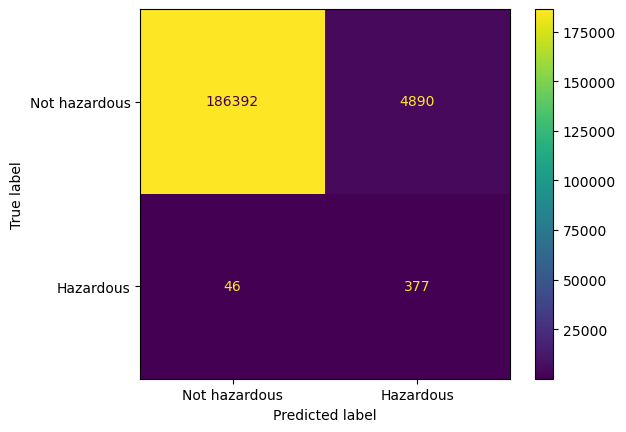

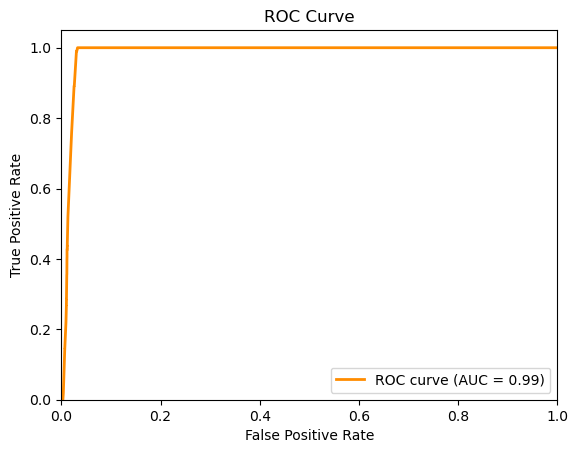

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not hazardous', 'Hazardous'])
plt.figure(figsize=(15, 15))
cm_display.plot()
plt.show()
fig1 = cm_display

fig1.figure_.savefig("confusion_matrix.png", dpi=100)




import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Plot ROC curve
plot_roc_curve(y_test, y_pred_proba)
